
# Introduction
<p align="center">
<img src="https://raw.githubusercontent.com/pbcquoc/vietocr/master/image/vietocr.jpg" width="512" height="512">
</p>
This notebook describe how you can use VietOcr to train OCR model




In [1]:
! pip install --quiet vietocr
! pip install -U pillow --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.9/133.9 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 94.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.5/313.5 kB 33.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 15.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
vietocr 0.3.13 requires pillow==10.2.0, but you have pillow 10.3.0 which is incom

In [2]:
!wget -nc https://vocr.vn/data/vietocr/vgg_seq2seq.pth --no-check-certificate

--2024-06-27 19:12:29--  https://vocr.vn/data/vietocr/vgg_seq2seq.pth
Resolving vocr.vn (vocr.vn)... 128.199.222.116
Connecting to vocr.vn (vocr.vn)|128.199.222.116|:443... connected.
  Issued certificate has expired.
HTTP request sent, awaiting response... 200 OK
Length: 89575371 (85M) [application/octet-stream]
Saving to: ‘vgg_seq2seq.pth’

vgg_seq2seq.pth     100%[===================>]  85.42M  16.0MB/s    in 6.7s    

2024-06-27 19:12:37 (12.7 MB/s) - ‘vgg_seq2seq.pth’ saved [89575371/89575371]



In [5]:
%%writefile vgg_transformer.yml
# change to list chars of your dataset or use default vietnamese chars
vocab: 'aAàÀảẢãÃáÁạẠăĂằẰẳẲẵẴắẮặẶâÂầẦẩẨẫẪấẤậẬbBcCdDđĐeEèÈẻẺẽẼéÉẹẸêÊềỀểỂễỄếẾệỆfFgGhHiIìÌỉỈĩĨíÍịỊjJkKlLmMnNoOòÒỏỎõÕóÓọỌôÔồỒổỔỗỖốỐộỘơƠờỜởỞỡỠớỚợỢpPqQrRsStTuUùÙủỦũŨúÚụỤưƯừỪửỬữỮứỨựỰvVwWxXyYỳỲỷỶỹỸýÝỵỴzZ0123456789!"#$%&''()*+,-./:;<=>?@[\]^_`{|}~ '

# cpu, cuda, cuda:0
device: cuda:0

# for train
pretrain: /content/vgg_seq2seq.pth

# url or local path (for predict)
weights: /content/vgg_seq2seq.pth

backbone: vgg19_bn
cnn:
    # pooling stride size
    ss:
        - [2, 2]
        - [2, 2]
        - [2, 1]
        - [2, 1]
        - [1, 1]
    # pooling kernel size
    ks:
        - [2, 2]
        - [2, 2]
        - [2, 1]
        - [2, 1]
        - [1, 1]
    # dim of ouput feature map
    hidden: 256

seq_modeling: seq2seq
transformer:
    encoder_hidden: 256
    decoder_hidden: 256
    img_channel: 256
    decoder_embedded: 256
    dropout: 0.1

optimizer:
    max_lr: 0.001
    pct_start: 0.1

trainer:
    batch_size: 32
    print_every: 200
    valid_every: 4000
    iters: 100000
    # where to save our model for prediction
    export: ./weights/transformerocr.pth
    checkpoint: ./checkpoint/transformerocr_checkpoint.pth
    log: ./train.log
    # null to disable compuate accuracy, or change to number of sample to enable validiation while training
    metrics: null

dataset:
    # name of your dataset
    name: data_line
    # path to annotation and image
    data_root: /content/data_line
    train_annotation: train_line_annotation.txt
    valid_annotation: test_line_annotation.txt
    # resize image to 32 height, larger height will increase accuracy
    image_height: 32
    image_min_width: 32
    image_max_width: 512

dataloader:
    num_workers: 2
    pin_memory: True

aug:
    image_aug: true
    masked_language_model: true

predictor:
    # disable or enable beamsearch while prediction, use beamsearch will be slower
    beamsearch: False

quiet: False

Overwriting vgg_transformer.yml


# Inference

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image

from vietocr.tool.predictor import Predictor
from vietocr.tool.config import Cfg

In [ ]:
config = Cfg.load_config_from_file('/content/vgg_transformer.yml')

Change weights to your weights or using default weights from our pretrained model. Path can be url or local file

In [ ]:
# config['weights'] = './weights/transformerocr.pth'
# config['cnn']['pretrained'] = False
# config['device'] = 'cuda:0'

In [ ]:
detector = Predictor(config)

In [ ]:
! wget https://vocr.vn/data/vietocr/sample.zip --no-check-certificate
! unzip  -qq -o sample.zip

--2024-06-27 18:21:27--  https://vocr.vn/data/vietocr/sample.zip
Resolving vocr.vn (vocr.vn)... 128.199.222.116
Connecting to vocr.vn (vocr.vn)|128.199.222.116|:443... connected.
  Issued certificate has expired.
HTTP request sent, awaiting response... 200 OK
Length: 305969 (299K) [application/zip]
Saving to: ‘sample.zip’

sample.zip          100%[===================>] 298.80K  --.-KB/s    in 0.004s  

2024-06-27 18:21:27 (82.6 MB/s) - ‘sample.zip’ saved [305969/305969]



In [ ]:
! ls sample | shuf |head -n 5

036301002139.jpeg
deskewed-_2019_10_03_20191003002690_2019100308491067310_4.jpg
038094001443.jpeg
026200002854.jpeg
30036.jpg


'Liên Hiệp Quốc vừa tuyên bố ngày 19-11 hằng năm là Ngày Toilet Thế giới, bắt đầu từ năm 2013'

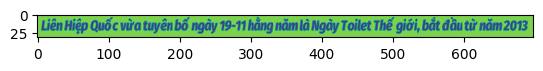

In [ ]:
img = '/content/sample/00019816.jpg'
img = Image.open(img)
plt.imshow(img)
s = detector.predict(img)
s

# Download sample dataset

In [6]:
! wget https://vocr.vn/data/vietocr/data_line.zip --no-check-certificate

--2024-06-27 19:13:18--  https://vocr.vn/data/vietocr/data_line.zip
Resolving vocr.vn (vocr.vn)... 128.199.222.116
Connecting to vocr.vn (vocr.vn)|128.199.222.116|:443... connected.
  Issued certificate has expired.
HTTP request sent, awaiting response... 200 OK
Length: 61212284 (58M) [application/zip]
Saving to: ‘data_line.zip’

data_line.zip       100%[===================>]  58.38M  17.6MB/s    in 4.3s    

2024-06-27 19:13:23 (13.7 MB/s) - ‘data_line.zip’ saved [61212284/61212284]



In [7]:
! unzip -qq -o ./data_line.zip

# Train model



1.   Load your config
2.   Train model using your dataset above



Load the default config, we adopt VGG for image feature extraction

In [8]:
from vietocr.tool.config import Cfg
from vietocr.model.trainer import Trainer

# Change the config

* *data_root*: the folder save your all images
* *train_annotation*: path to train annotation
* *valid_annotation*: path to valid annotation
* *print_every*: show train loss at every n steps
* *valid_every*: show validation loss at every n steps
* *iters*: number of iteration to train your model
* *export*: export weights to folder that you can use for inference
* *metrics*: number of sample in validation annotation you use for computing full_sequence_accuracy, for large dataset it will take too long, then you can reuduce this number


In [9]:
config = Cfg.load_config_from_file('/content/vgg_transformer.yml')

In [10]:

dataset_params = {
    'name':'test',
    'data_root':'/content/data_line',
    'train_annotation':'train_line_annotation.txt',
    'valid_annotation':'test_line_annotation.txt'
}

params = {
         'print_every':200,
         'valid_every':15*200,
          'iters':20000,
          'checkpoint':'./checkpoint/seq2seqocr_checkpoint.pth',
          'export':'./weights/seq2seqocr.pth',
          'metrics': 10000
         }

config['trainer'].update(params)
config['dataset'].update(dataset_params)
config['device'] = 'cuda:0'

you can change any of these params in this full list below

In [11]:
config

{'vocab': 'aAàÀảẢãÃáÁạẠăĂằẰẳẲẵẴắẮặẶâÂầẦẩẨẫẪấẤậẬbBcCdDđĐeEèÈẻẺẽẼéÉẹẸêÊềỀểỂễỄếẾệỆfFgGhHiIìÌỉỈĩĨíÍịỊjJkKlLmMnNoOòÒỏỎõÕóÓọỌôÔồỒổỔỗỖốỐộỘơƠờỜởỞỡỠớỚợỢpPqQrRsStTuUùÙủỦũŨúÚụỤưƯừỪửỬữỮứỨựỰvVwWxXyYỳỲỷỶỹỸýÝỵỴzZ0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~ ',
 'device': 'cuda:0',
 'pretrain': '/content/vgg_seq2seq.pth',
 'weights': '/content/vgg_seq2seq.pth',
 'backbone': 'vgg19_bn',
 'cnn': {'ss': [[2, 2], [2, 2], [2, 1], [2, 1], [1, 1]],
  'ks': [[2, 2], [2, 2], [2, 1], [2, 1], [1, 1]],
  'hidden': 256},
 'seq_modeling': 'seq2seq',
 'transformer': {'encoder_hidden': 256,
  'decoder_hidden': 256,
  'img_channel': 256,
  'decoder_embedded': 256,
  'dropout': 0.1},
 'optimizer': {'max_lr': 0.001, 'pct_start': 0.1},
 'trainer': {'batch_size': 32,
  'print_every': 200,
  'valid_every': 3000,
  'iters': 20000,
  'export': './weights/seq2seqocr.pth',
  'checkpoint': './checkpoint/seq2seqocr_checkpoint.pth',
  'log': './train.log',
  'metrics': 10000},
 'dataset': {'name': 'test',
  'data_root': '/content/

You should train model from our pretrained

In [12]:
trainer = Trainer(config, pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:03<00:00, 148MB/s]
Create train_test: 100%|██████████████████████████████████████| 5483/5483 [00:04<00:00, 1323.68it/s]


Created dataset with 5482 samples


Create valid_test: 100%|██████████████████████████████████████| 1813/1813 [00:01<00:00, 1686.58it/s]

Created dataset with 1812 samples



valid_test build cluster: 100%|█████████████████████████████| 1812/1812 [00:00<00:00, 139812.71it/s]


Freeze feature extractor

In [ ]:
for layer, weight in detector.model.named_parameters():
    if 'cnn.model.features' in layer:
        weight.requires_grad = False

Save model configuration for inference, load_config_from_file

In [13]:
trainer.config.save('config.yml')

Visualize your dataset to check data augmentation is appropriate

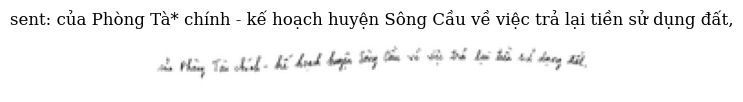

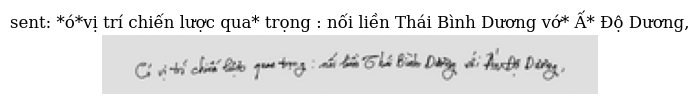

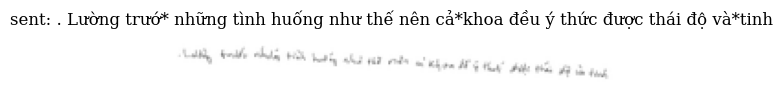

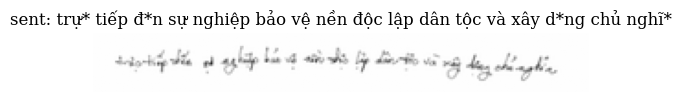

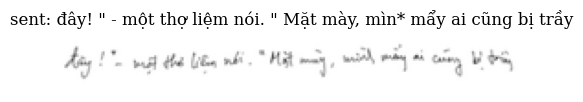

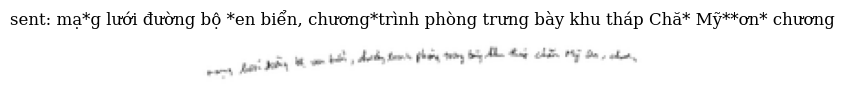

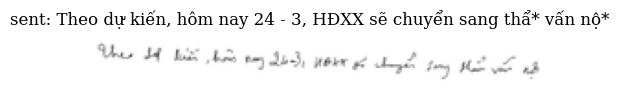

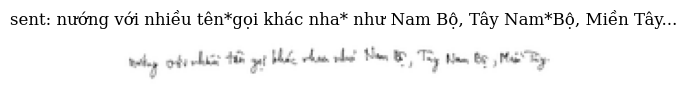

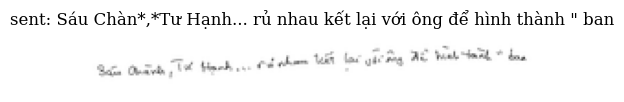

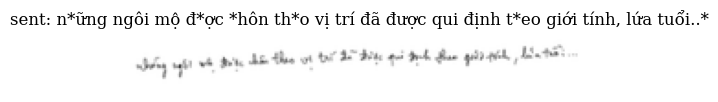

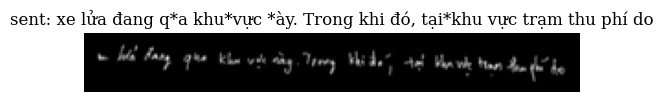

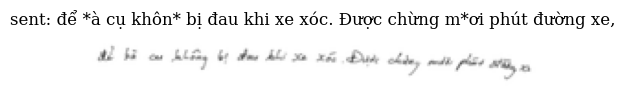

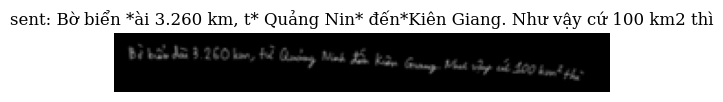

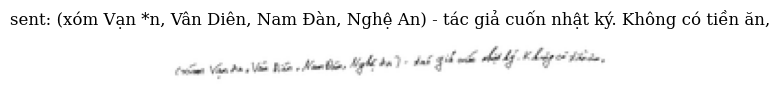

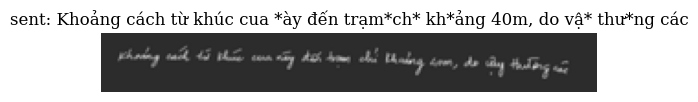

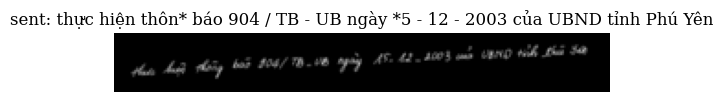

In [ ]:
trainer.visualize_dataset()

Train now

In [14]:
trainer.train()

iter: 000200 - train loss: 1.411 - lr: 6.35e-05 - load time: 0.91 - gpu time: 102.57
iter: 000400 - train loss: 1.199 - lr: 1.32e-04 - load time: 0.52 - gpu time: 102.02
iter: 000600 - train loss: 1.106 - lr: 2.38e-04 - load time: 0.62 - gpu time: 101.99
iter: 000800 - train loss: 1.034 - lr: 3.72e-04 - load time: 0.92 - gpu time: 101.27
iter: 001000 - train loss: 0.981 - lr: 5.20e-04 - load time: 0.61 - gpu time: 102.56
iter: 001200 - train loss: 0.958 - lr: 6.69e-04 - load time: 0.53 - gpu time: 100.69
iter: 001400 - train loss: 0.920 - lr: 8.03e-04 - load time: 1.08 - gpu time: 103.66
iter: 001600 - train loss: 0.908 - lr: 9.09e-04 - load time: 0.52 - gpu time: 101.70
iter: 001800 - train loss: 0.888 - lr: 9.77e-04 - load time: 0.52 - gpu time: 102.29
iter: 002000 - train loss: 0.865 - lr: 1.00e-03 - load time: 0.54 - gpu time: 101.35
iter: 002200 - train loss: 0.846 - lr: 1.00e-03 - load time: 0.95 - gpu time: 101.50
iter: 002400 - train loss: 0.845 - lr: 9.99e-04 - load time: 0.63

KeyboardInterrupt: 

Visualize prediction from our trained model


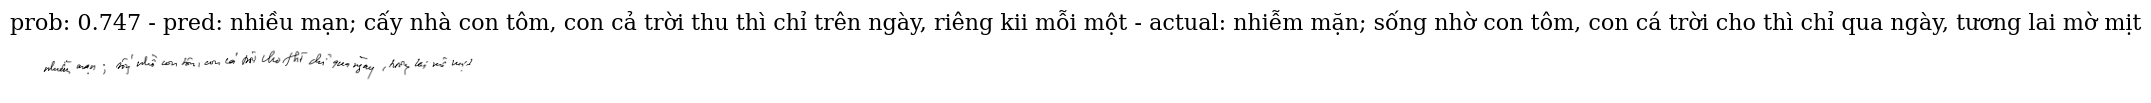

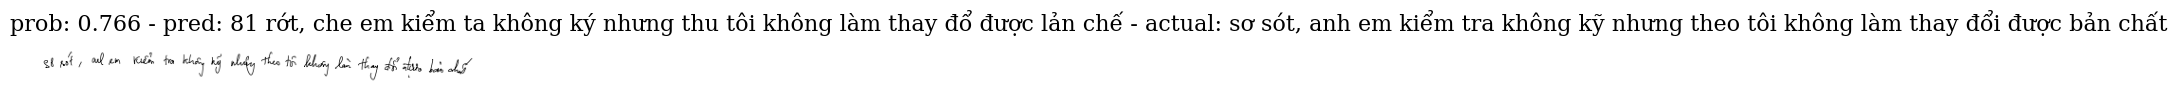

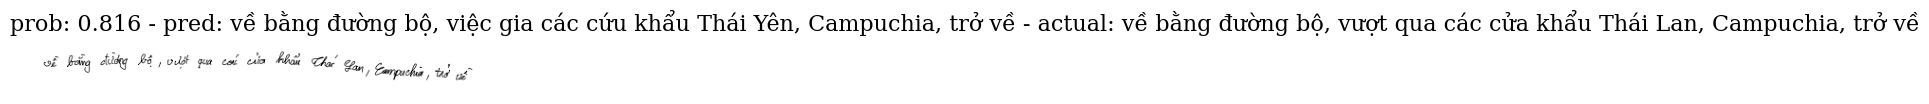

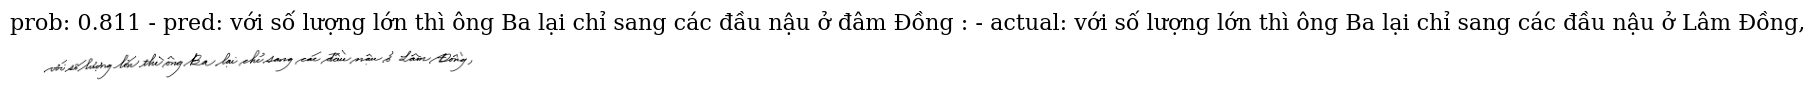

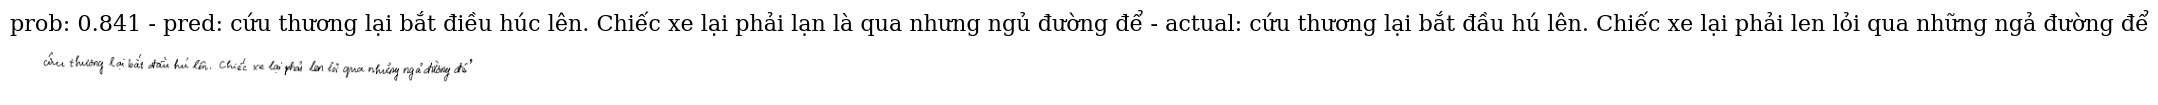

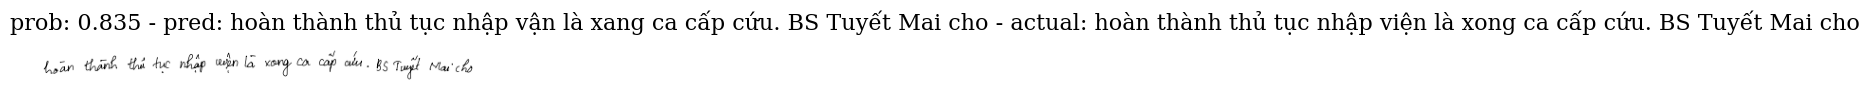

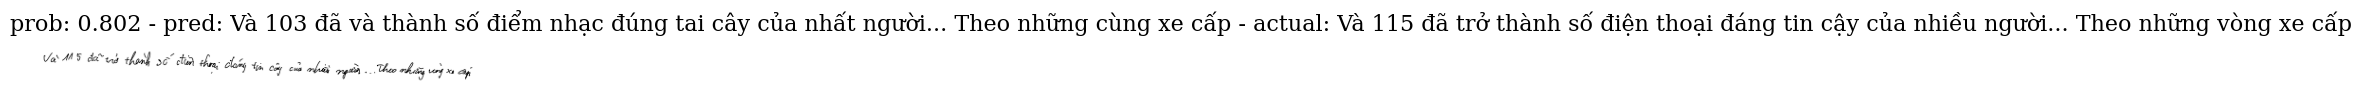

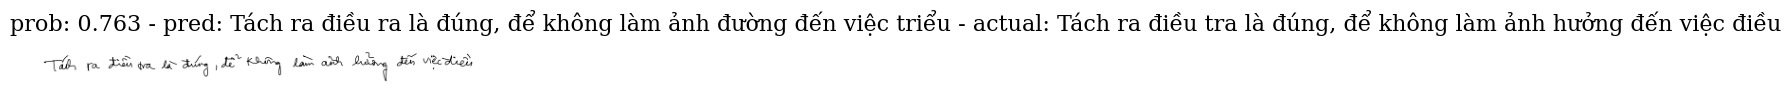

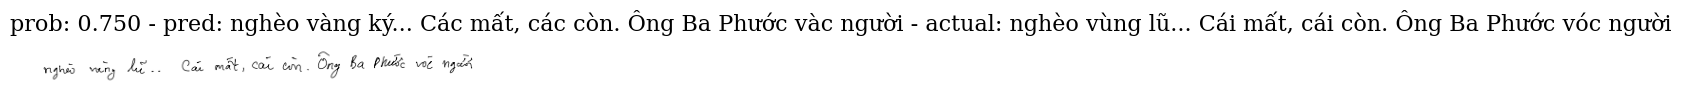

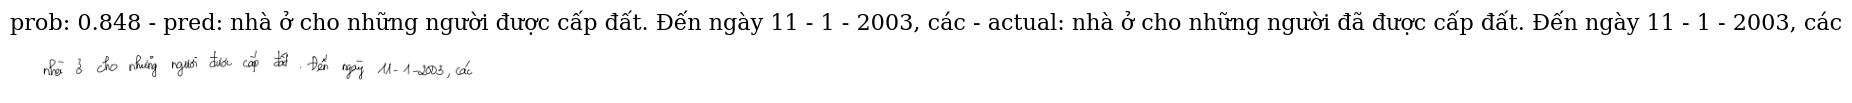

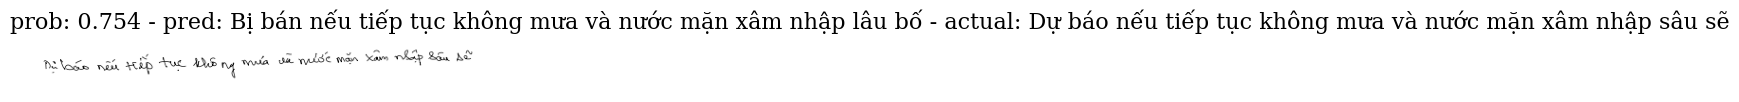

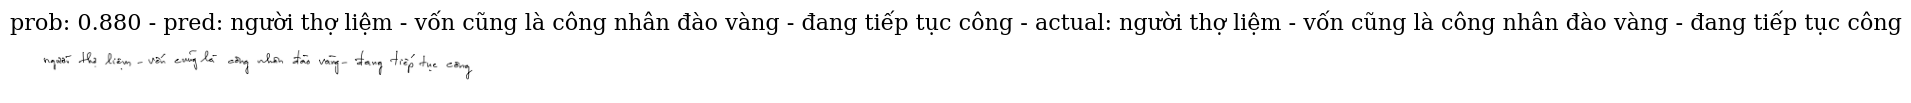

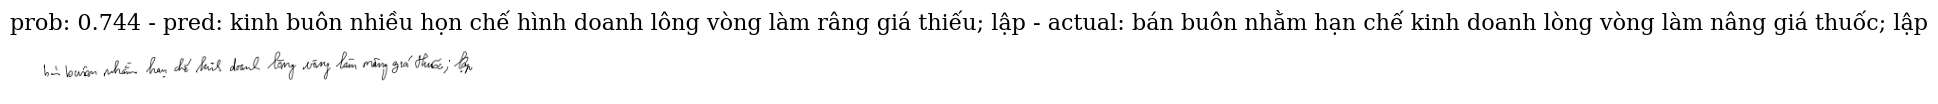

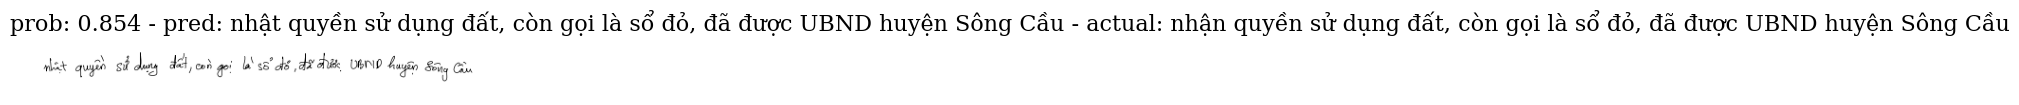

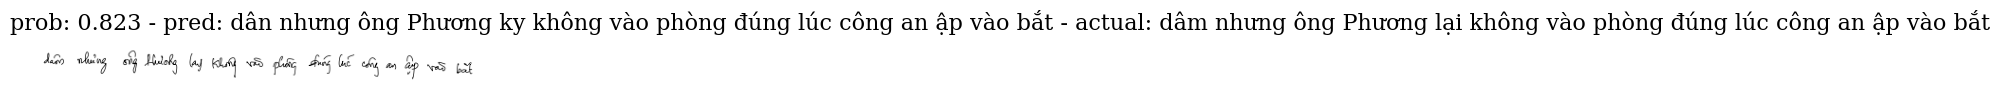

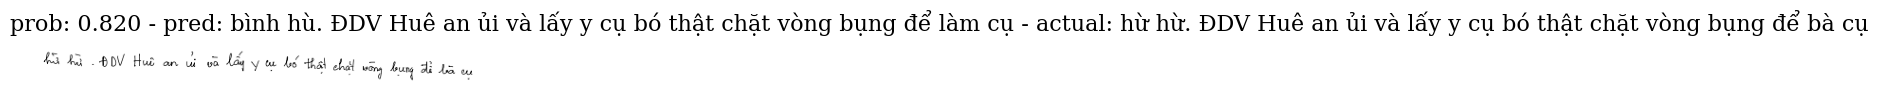

In [16]:
trainer.visualize_prediction()

Compute full seq accuracy for full valid dataset

In [15]:
trainer.precision()

(0.06321022727272728, 0.6100817)